# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')

# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


- Our dataset contains 12 columns, and the last column is the output variable (pm2.5) which contains null values.


- The first column is just for indexing purposes and won't really matter when it comes to buildig the model later.

In [ ]:
# Datatypes in this dataset
train.dtypes

,0
No,int64
DEWP,float64
TEMP,float64
PRES,float64
Iws,float64
Is,float64
Ir,float64
datetime,object
cbwd_NW,float64
cbwd_SE,float64


All the variables are either integers or floats. The only thing that is an object is datetime which we will modify later on.

In [ ]:
# Gives detailed summary statistics
train.describe()

,No,DEWP,TEMP,PRES,Iws,Is,Ir,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
count,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,30676.000000,28755.000000
mean,15338.500000,-0.029431,-0.062712,0.013612,0.030542,0.016992,0.011253,0.016193,0.005833,-0.025008,100.793427
std,8855.542765,0.994087,1.015193,1.008991,1.018337,1.087278,1.063811,1.006001,1.001847,0.982122,93.144433
min,1.000000,-2.135153,-2.578070,-2.380821,-0.468688,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,0.000000
25%,7669.750000,-0.888034,-0.938521,-0.822670,-0.441894,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,29.000000
50%,15338.500000,-0.056622,0.045209,-0.043595,-0.352512,-0.069353,-0.137667,-0.690542,-0.732019,-0.522096,75.000000
75%,23007.250000,0.913358,0.864984,0.832865,0.005216,-0.069353,-0.137667,1.448138,1.366085,-0.522096,142.000000
max,30676.000000,1.814055,2.340578,2.877939,11.231956,35.439859,25.288745,1.448138,1.366085,1.915355,994.000000


Some insights from the summary statistics are:
- There are 30676 rows in the dataset.
- Dew point values range from -2.14 to 1.81.
- Temperature values seem to be freezing from their mean which is on the negative side.

In [ ]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace = True)
# val.set_index('datetime', inplace = True)
test.set_index('datetime', inplace = True)


# Data Visualizations

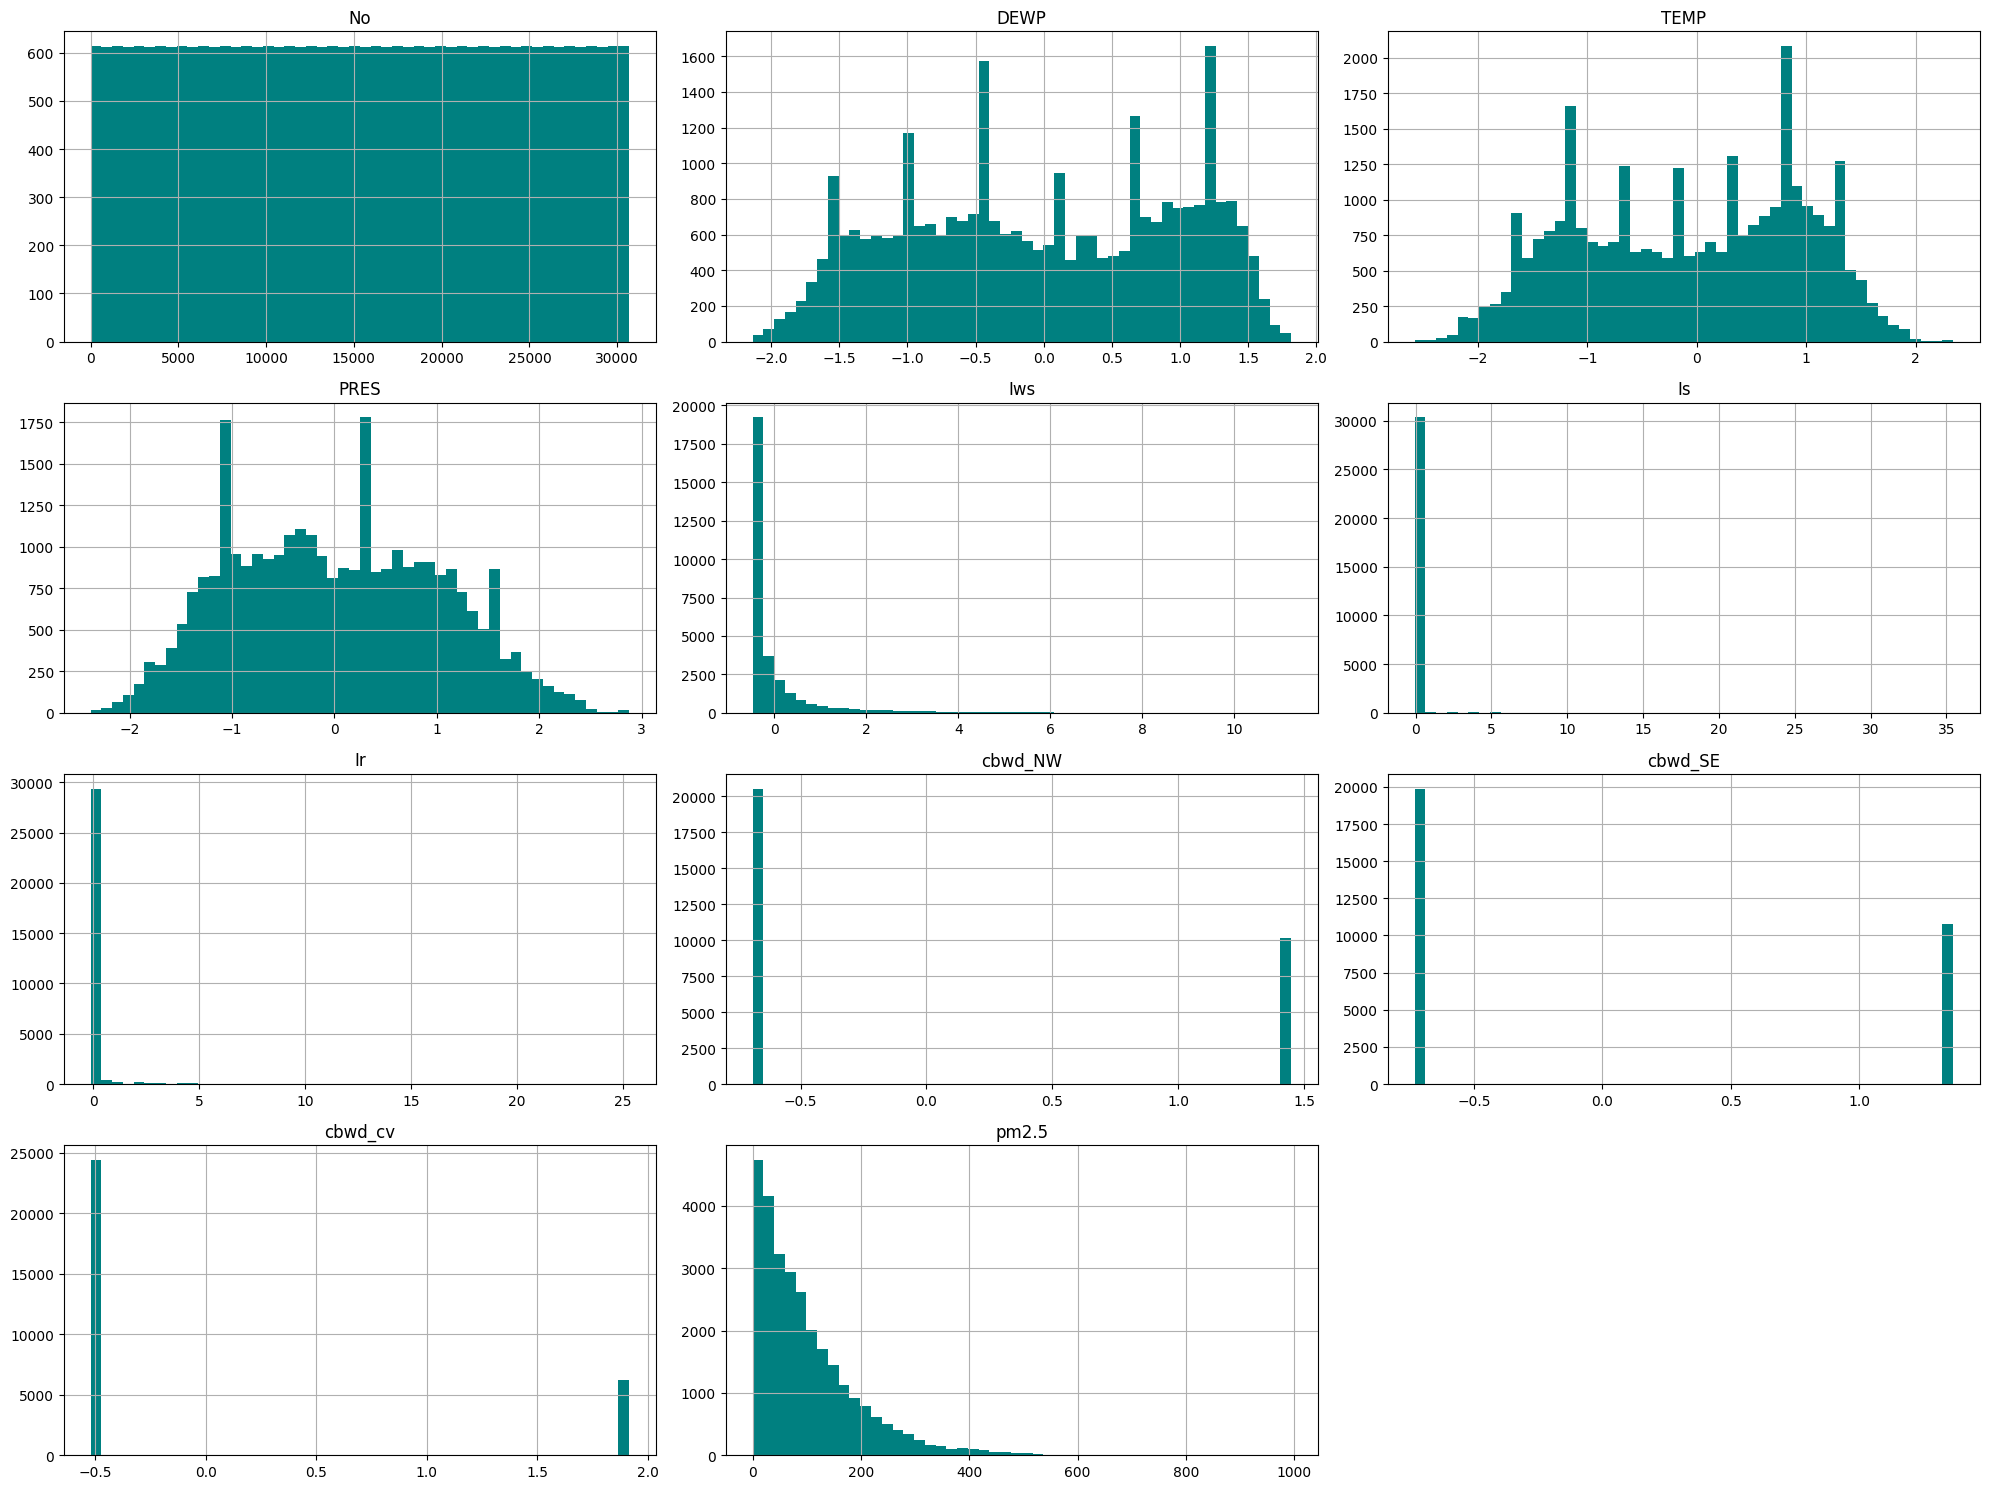

In [ ]:
# Plot histograms for all tthe variables
train.hist(bins = 50, figsize = (20, 15), color = 'teal')
plt.tight_layout()
plt.show()

- Temperature (TEMP), Dew Point (DEWP), Pressure (PRES) have roughly normal distributions with discrete peaks.

- Rain-related variables (Ir, Is) are highly right-skewed, which means that rain is not frequent.

- lws(windspeed) is skewed to the right, with most instances being low widn speeds but also there are strong winds.

- pm2.5 is right skewed but with some potential outliers.

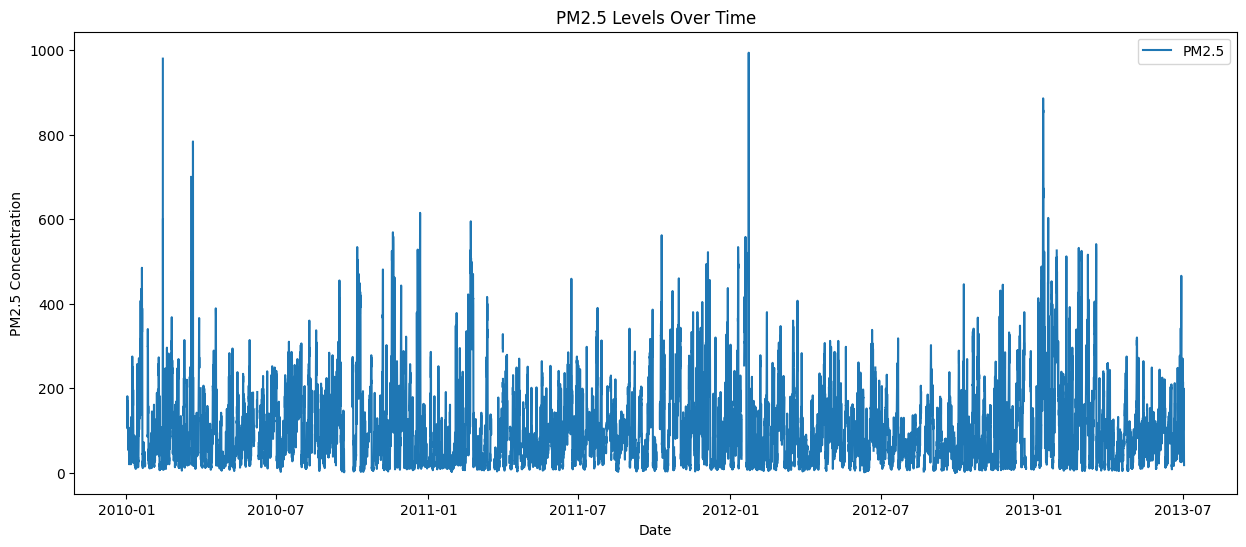

In [ ]:
# PM2.5 trend over time
plt.figure(figsize = (15, 6))
plt.plot(train.index, train['pm2.5'], label = 'PM2.5')
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.show()

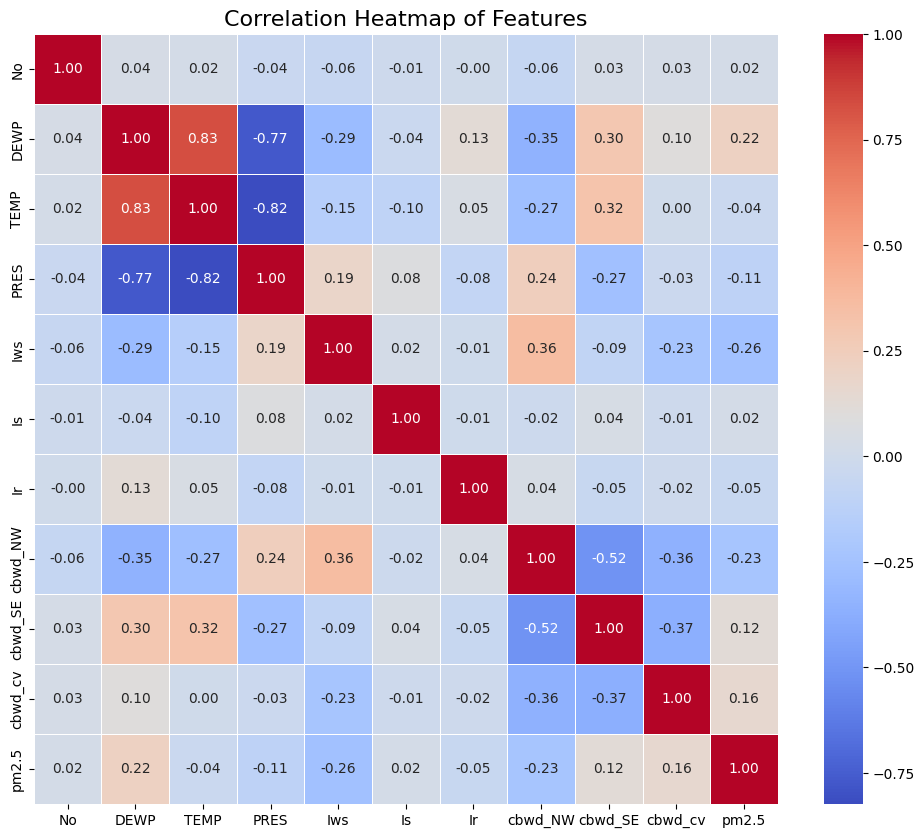

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = train.corr()

# Set up the matplotlib figure
plt.figure(figsize = (12, 10))

# Draw the heatmap
sns.heatmap(corr_matrix, annot = True, fmt = ".2f", cmap = 'coolwarm', linewidths = 0.5)

# Add title
plt.title("Correlation Heatmap of Features", fontsize = 16)
plt.show()

- TEMP and DEWP have a strong positive correlation (0.83), which may mean that warmer air holds more moisture.

- TEMP and PRES have a strong negative correlation (-0.82), which may indicate that higher temperatures often reduce air pressure.

- pm2.5 is positively correlated with DEWP (0.22), which may mean that humid conditions may trap pollutants.

- pm2.5 is negatively correlated with Iws (-0.26), which may mean stronger winds reduce pollution.

- cbwd_NW is negatively correlated with pm2.5 (−0.23), which indicates that NW winds help clear air pollutants.

It is fair to say that all variables play a key role in this dataset, so we'll build our model with all of them.

# Handle missing values


- Check the dataset for missing values and decide how to handle them.

In [ ]:
# Check for missing values
print("Missing Values in Training Data:")
print(train.isnull().sum())

Missing Values in Training Data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


In [ ]:
# Drop rows with missing values
train_cleaned = train.dropna()

print("Missing values after dropping:")
print(train_cleaned.isnull().sum().sum())

print("Remaining rows:", train_cleaned.shape[0])

Missing values after dropping:
0
Remaining rows: 28755


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
# X_train features for training. Going to drop target and No
X_train = train_cleaned.drop(['pm2.5', 'No'], axis = 1)
# y_train which is the target variable
y_train = train_cleaned['pm2.5']

In [ ]:
# Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
# Time windowing

def create_windows(data, window_size, step_size):
    windows = []
    # Iterates through the data, creating windows
    for i in range(0, len(data) - window_size + 1, step_size):
        # Extract a window od data
        window = data[i:i + window_size]
        # Add window to list of windows
        windows.append(window)
    # Converts list of windows to Np array
    return np.array(windows)

# Each window contain 24 hrs
window_size = 24
step_size = 1 # Moving the window by 1 hr at a time

# Creates the windows
X_train_windows = create_windows(X_train_scaled, window_size, step_size)

In [ ]:
# Creating Input-output sequences

# Creates target sequences starting from index to end of target data
# Then converts to a numpy array
y_train_windows = y_train[window_size - 1:].values

print(X_train_windows.shape) # Prints shape of input windows(X)
print(y_train_windows.shape) # Prints shape of target Y


(28732, 24, 9)
(28732,)


In [ ]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train_lstm = X_train_windows.reshape((X_train_windows.shape[0],
                                        X_train_windows.shape[1],
                                        X_train_scaled.shape[1]))

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop, SGD

# define model
model = Sequential([
    LSTM(32, activation = 'tanh', input_shape = (window_size, X_train.shape[1]),
         return_sequences = True, kernel_regularizer = l2(0.01)),
    Dropout(0.5),
    LSTM(16, activation = 'tanh', kernel_regularizer = l2(0.01)),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = 'mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                  │ (None, 24, 32)         │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,529 (33.32 KB)

 Trainable params: 8,529 (33.32 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history = model.fit(
    X_train_lstm, y_train_windows,
    epochs = 50,
    batch_size = 32,
    validation_split = 0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - lambda: 126.3073 - loss: 16509.9316 - val_lambda: 111.5855 - val_loss: 20375.4336
Epoch 2/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - lambda: 118.0049 - loss: 14401.3252 - val_lambda: 104.1305 - val_loss: 18379.7520
Epoch 3/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step - lambda: 109.9771 - loss: 12653.8320 - val_lambda: 98.2611 - val_loss: 16740.0703
Epoch 4/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - lambda: 105.4441 - loss: 11586.4150 - val_lambda: 93.2109 - val_loss: 15296.5859
Epoch 5/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - lambda: 100.5253 - loss: 9869.7178 - val_lambda: 88.9205 - val_loss: 13922.9863
Epoch 6/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - lambda: 99.6875 - loss: 9050.0391 - val_lambda: 85.9366 - val_loss: 12778.5889
Epoch 7/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - lambda: 97.0336 - loss: 7988.0210 - val_lambda: 83.3838 - val_loss: 11803.1094
Epoch 8/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 20s 

898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


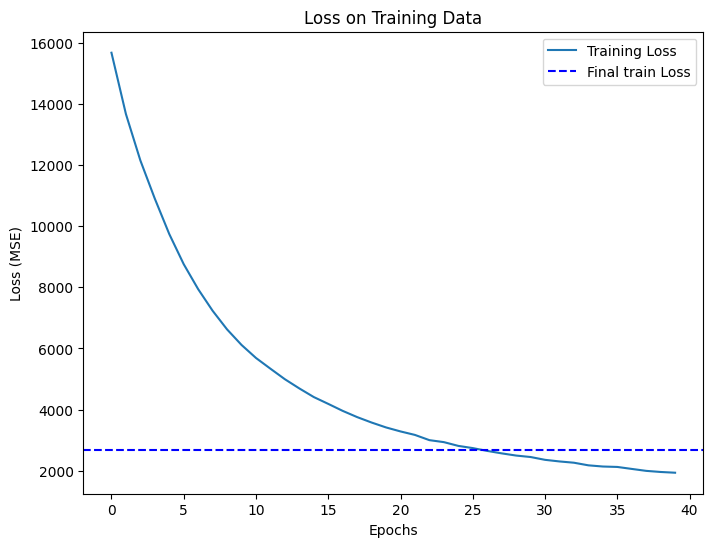

Final Training Loss (MSE): 2688.5224505136357


In [ ]:
# Calculate training loss
train_predictions = model.predict(X_train_lstm)
train_loss = np.mean((y_train_windows - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize = (8, 6))
plt.plot(history.history['loss'], label = 'Training Loss')  # Training loss during epochs
plt.axhline(y = train_loss, color = 'blue', linestyle = '--', label = 'Final train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

Final Training Loss (MSE): 2688.5224505136357


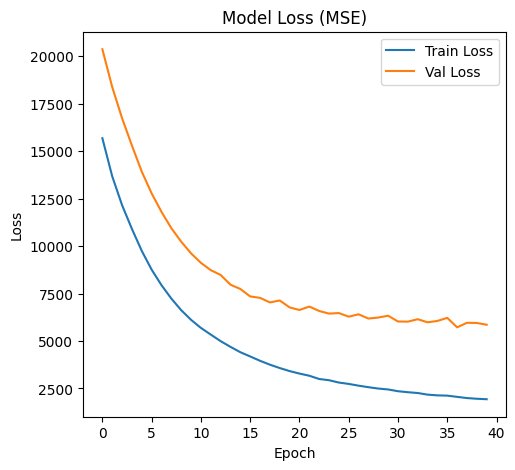

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


print(f"Final Training Loss (MSE): {train_loss}")

In [298]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test_scaled = scaler.transform(X_test)

# Pad the test data to get predictions for all rows
padding_size = window_size - 1  # Number of data points to pad
padded_X_test_scaled = np.pad(X_test_scaled, ((padding_size, 0), (0, 0)), mode='reflect')

X_test_windows = create_windows(padded_X_test_scaled, window_size, step_size)
X_test_lstm = X_test_windows.reshape((X_test_windows.shape[0], X_test_windows.shape[1], X_test_scaled.shape[1]))

# Make predictions
predictions = model.predict(X_test_lstm)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Remove the predictions corresponding to the padded data to match the original test set size
predictions = predictions[-len(test):]

# Prepare the submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID'
submission = submission.sort_values(by='row ID')

# Save the submission file
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
